In [1]:
import torch
import numpy as np
import math
import os
import pytorch_lightning as pl
import torch
from hydra.utils import instantiate
import matplotlib.pyplot as plt
from case_studies.redshift_estimation.catalog import RedshiftFullCatalog, RedshiftTileCatalog
from bliss.encoder.plotting import plot_detections, my_plot_detections

In [2]:
from os import environ
environ["CUDA_VISIBLE_DEVICES"] = "4"

from pathlib import Path
from hydra import initialize, compose
from bliss.main import predict

environ["BLISS_HOME"] = str("/home/declan/current/bliss")

In [3]:
with initialize(config_path="../", version_base=None):
    cfg = compose("redshift", {
        "predict.weight_save_path=/data/scratch/declan/sdss_encoder_ckpt.ckpt",
        "cached_simulator.cached_data_path=/data/scratch/declan/sdss_like_galaxies"
        })

# Training Evaluation of DC2-Like and SDSS-Like Simulated Images of Galaxies

### Prior Catalog Construction: SDSS

We use the spectrographic data release 17 to get redshifts. This is a large file containing unique IDs and redshifts for astronomical objects called `specObj-dr17.fits` that can be obtained from SDSS; we filter this to "clean" redshifts (i.e. those without warnings), and we remove duplicate measurments for the same object by filtering for the primary runs. Thereafter, we take the objects IDs and query SDSS for photometry values via the `astroquery.SDSS` module. After performing a join, we write the resulting dataframe of redshift and photometry values to a `.csv` file, and filter out photometry values that are missing or corrupt (for us, this is indicated by a value of -9999 for the band values).

Following this procedure results in about 1.14 million objects with known photometry and redshift values. These objects are comprised of galaxies, stars, and quasars. For now, we focus only on galaxies, so we perform a further filtering to consider galaxies only, yielding about 0.86 million objects.

Our SDSS-like prior of galaxies samples a vector of values `(redshift, u,g,r,i,z)` uniformly from these 0.86 million objects. As stated, for these validation experiments on semi-syntehtic data we only generate galaxies for now, so the `source_type` prior chooses galaxies with probability 1. The prior on galaxy parameters is unchanged. Together, all of these priors + GalSim define the SDSS-like generative model of images of galaxies.

### Semi-Synthetic Data: SDSS

Let's look at some images generated in this manner. We plot 10 example images, each in the $u,g,r,i,z$ bands. By default, BLISS chooses the SDSS survey with reference band $r$, and we make no modifications to this.

In [4]:
# This cell will take some time to run to load the dataset
pl.seed_everything(cfg.train.seed)

# setup dataset and encoder
dataset = instantiate(cfg.train.data_source)
encoder = instantiate(cfg.train.encoder)

Global seed set to 42


In [5]:
train_dataloader = dataset.train_dataloader() 
batch = next(iter(train_dataloader))
print('Batch of images is of shape {}'.format(batch['images'].shape))

Batch of images is of shape torch.Size([32, 5, 80, 80])


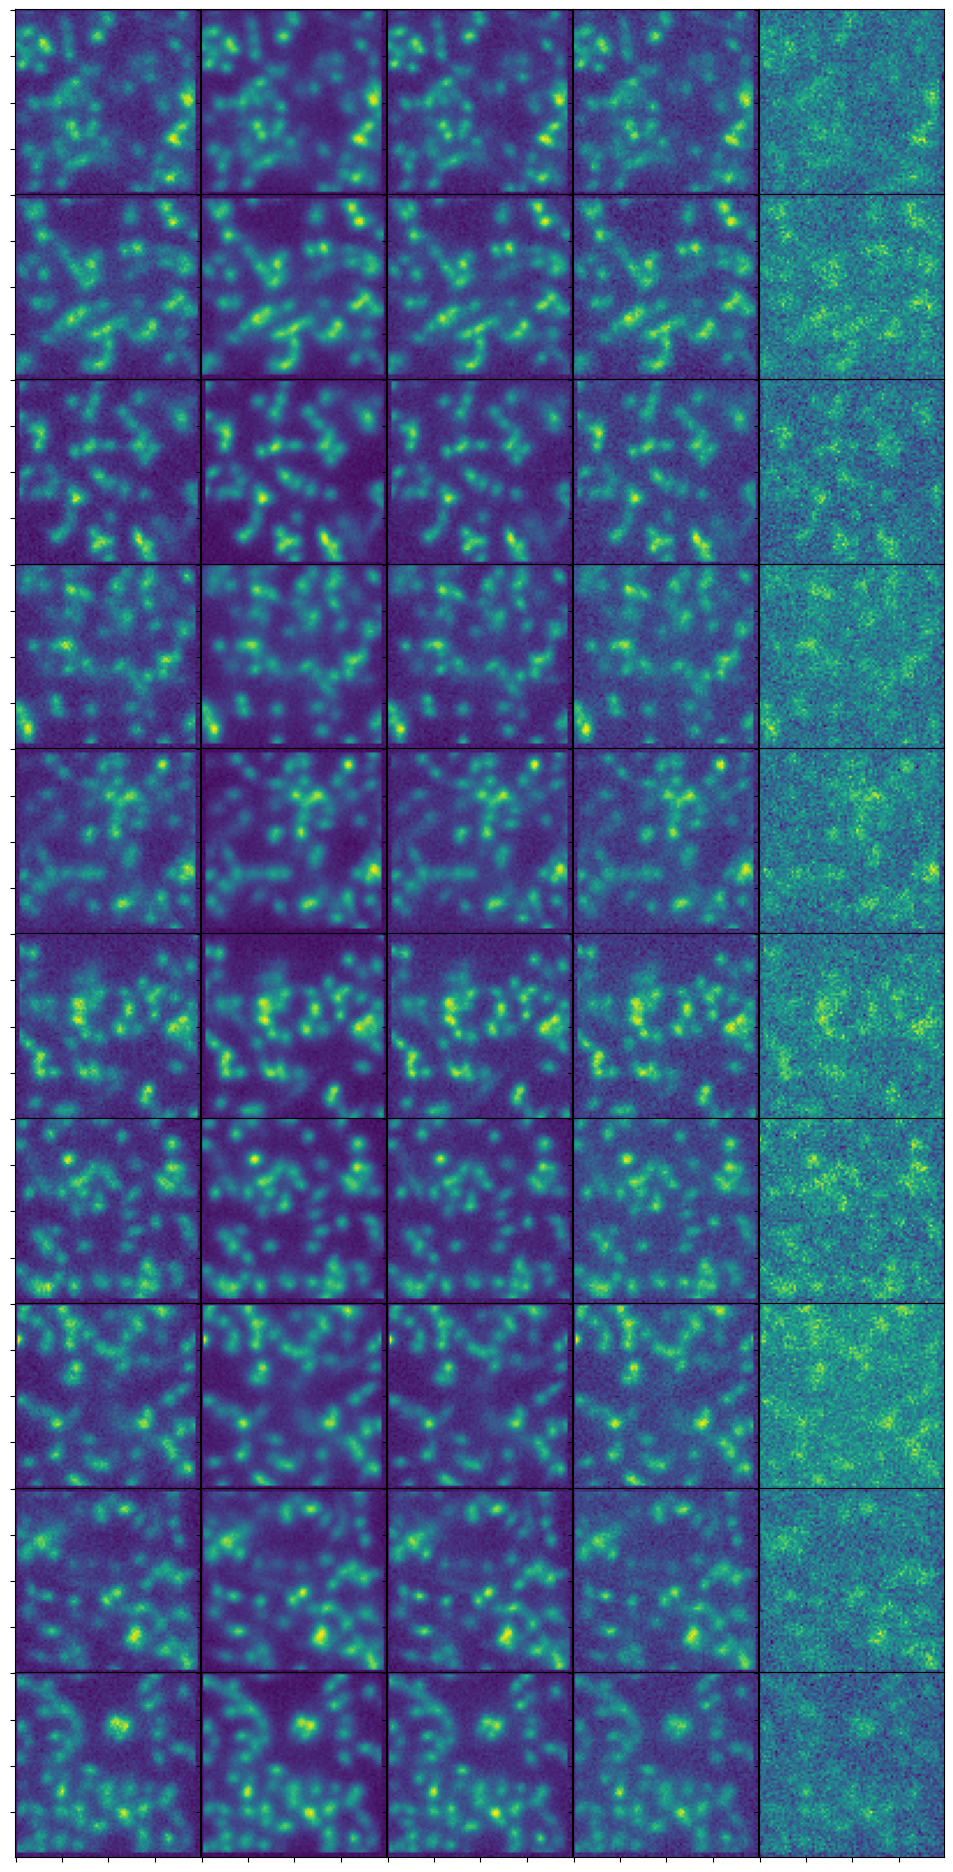

In [6]:
n_to_show = 10
_, axs = plt.subplots(10, 5, figsize=(12,24))
axs = axs.flatten()
imgs = batch['images'][:10].flatten(start_dim=0,end_dim=1)
for img, ax in zip(imgs, axs):
    ax.imshow(img)
    
for a in axs:
    a.set_xticklabels([])
    a.set_yticklabels([])

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### In-Sample Training Results: SDSS

We fit the encoder using the BLISS pipeline. Essentially, photo-$z$ estimation is performed via a module in parallel to the existing pipeline: the current pipeline estimates locations, types, and fluxes of each astronomical object. We simply add outputs to the encoder network that are used to parameterize the variational distributions on redshift.

Currently, the variational distributions on redshift are univariate Gaussian; a mixture of Gaussians could be used in the future. As with other quantities, the per-tile NLL contribution for redshift is conditioned on the presence of a true source in that tile, etc. We leave other aspects of BLISS unchanged, so in addition we also estimate the number of sources, the type of each source, the fluxes and galaxy parameters of each source, etc.

Let's load the fitted encoder and check that we are detecting sources properly. We overlay red "x"s on the posterior mode per-tile of the detected source, if a source is detected in that tile. We'll just overlay on top of the r-band image, as we don't have coaddition support for SDSS.

In [7]:
PATH = "/data/scratch/declan/sdss_encoder_ckpt.ckpt"
checkpoint = torch.load(PATH)
encoder.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [8]:
est_cat = encoder.sample(batch, use_mode=True) # I'm using the mode to predict
est_cat = est_cat.to_dict()

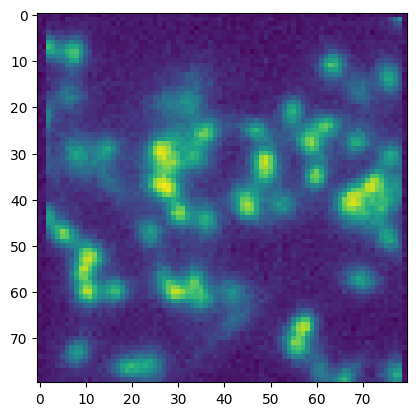

In [9]:
# Plot r_band for a selected image, overlay detected source locations
image_to_show = 5
fig, ax = plt.subplots()
ax.imshow(batch['images'][image_to_show].sum(0)) # Coadd by simple summation

In [10]:
target_cat = RedshiftTileCatalog(encoder.tile_slen, batch["tile_catalog"])
target_cat = target_cat.filter_tile_catalog_by_flux(min_flux=encoder.min_flux_threshold)
target_cat_cropped = target_cat.symmetric_crop(encoder.tiles_to_crop)
est_cat = encoder.sample(batch, use_mode=True)

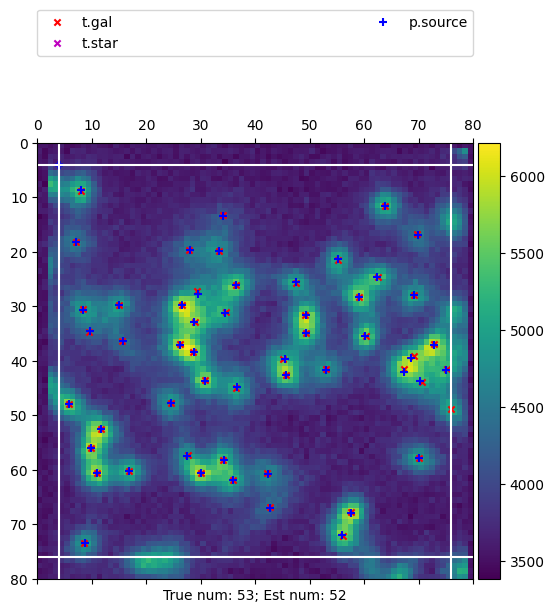

In [11]:
mp = encoder.tiles_to_crop * encoder.tile_slen
fig = my_plot_detections(image_to_show, batch["images"], target_cat_cropped, est_cat, margin_px=mp, figsize=(6,6))

Evidently, we're not doing terribly at predicting sources or their locations; let's assume then that we havne't broken the existing functionality of BLISS. We're interested in the quality of our photometric redshift estimates though. Let's plot these in a scatterplot across the whole training set. This will be quite a dense scatterplot because of the sheer number of images we train on.

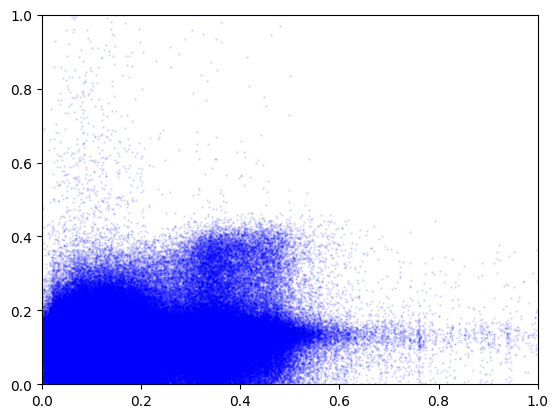

In [14]:
fig, ax = plt.subplots()


for idx, batch in enumerate(train_dataloader):
    est_cat = encoder.sample(batch, use_mode=True)
    pred_redshifts = est_cat.to_dict()['redshifts']
    true_redshifts = batch['tile_catalog']['redshifts']
    
    # Cut out border of true_redshifts
    true_redshifts = true_redshifts[:,1:-1,1:-1]
    true_redshifts = true_redshifts.squeeze(-1)
    
    # Add this batch to scatterplot
    ax.scatter(true_redshifts.detach().numpy(), pred_redshifts.detach().numpy(), c='b', marker='.', s=3, alpha=0.1)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    
    if idx > 100:
        break

Not great, but better!

In [15]:
training_mean = 0.
for idx, batch in enumerate(train_dataloader):
    true_redshifts = batch['tile_catalog']['redshifts']
    n_batch = 32*18*18
    sum_this_batch = true_redshifts.sum()
    training_mean = (training_mean * (idx * n_batch) + sum_this_batch)/((idx+1)*n_batch)
    
print('Mean of Training Redshifts: {}'.format(training_mean))

Mean of Training Redshifts: 0.17945173382759094


### Prior Catalog Construction: DC2

We use the DC2 truth tables to get redshifts and photometry values. There is a large number of galaxies in these, so we filter down to only about 5 million or so to use in our empirical prior. As above, the prior of galaxies samples a vector of values `(redshift, u,g,r,i,z)` uniformly from these objects. 

As above, we only sample galaxies not stars.

In [16]:
with initialize(config_path="../", version_base=None):
    cfg = compose("redshift", {
        "predict.weight_save_path=/data/scratch/declan/dc2_encoder_ckpt.ckpt",
        "cached_simulator.cached_data_path=/data/scratch/declan/dc2_like_galaxies"
        })

### Semi-Synthetic Data: DC2

In [17]:
# This cell will take some time to run to load the dataset
pl.seed_everything(cfg.train.seed)

# setup dataset and encoder
dataset = instantiate(cfg.train.data_source)
encoder = instantiate(cfg.train.encoder)

Global seed set to 42


In [18]:
train_dataloader = dataset.train_dataloader() 
batch = next(iter(train_dataloader))
print('Batch of images is of shape {}'.format(batch['images'].shape))

Batch of images is of shape torch.Size([32, 5, 80, 80])


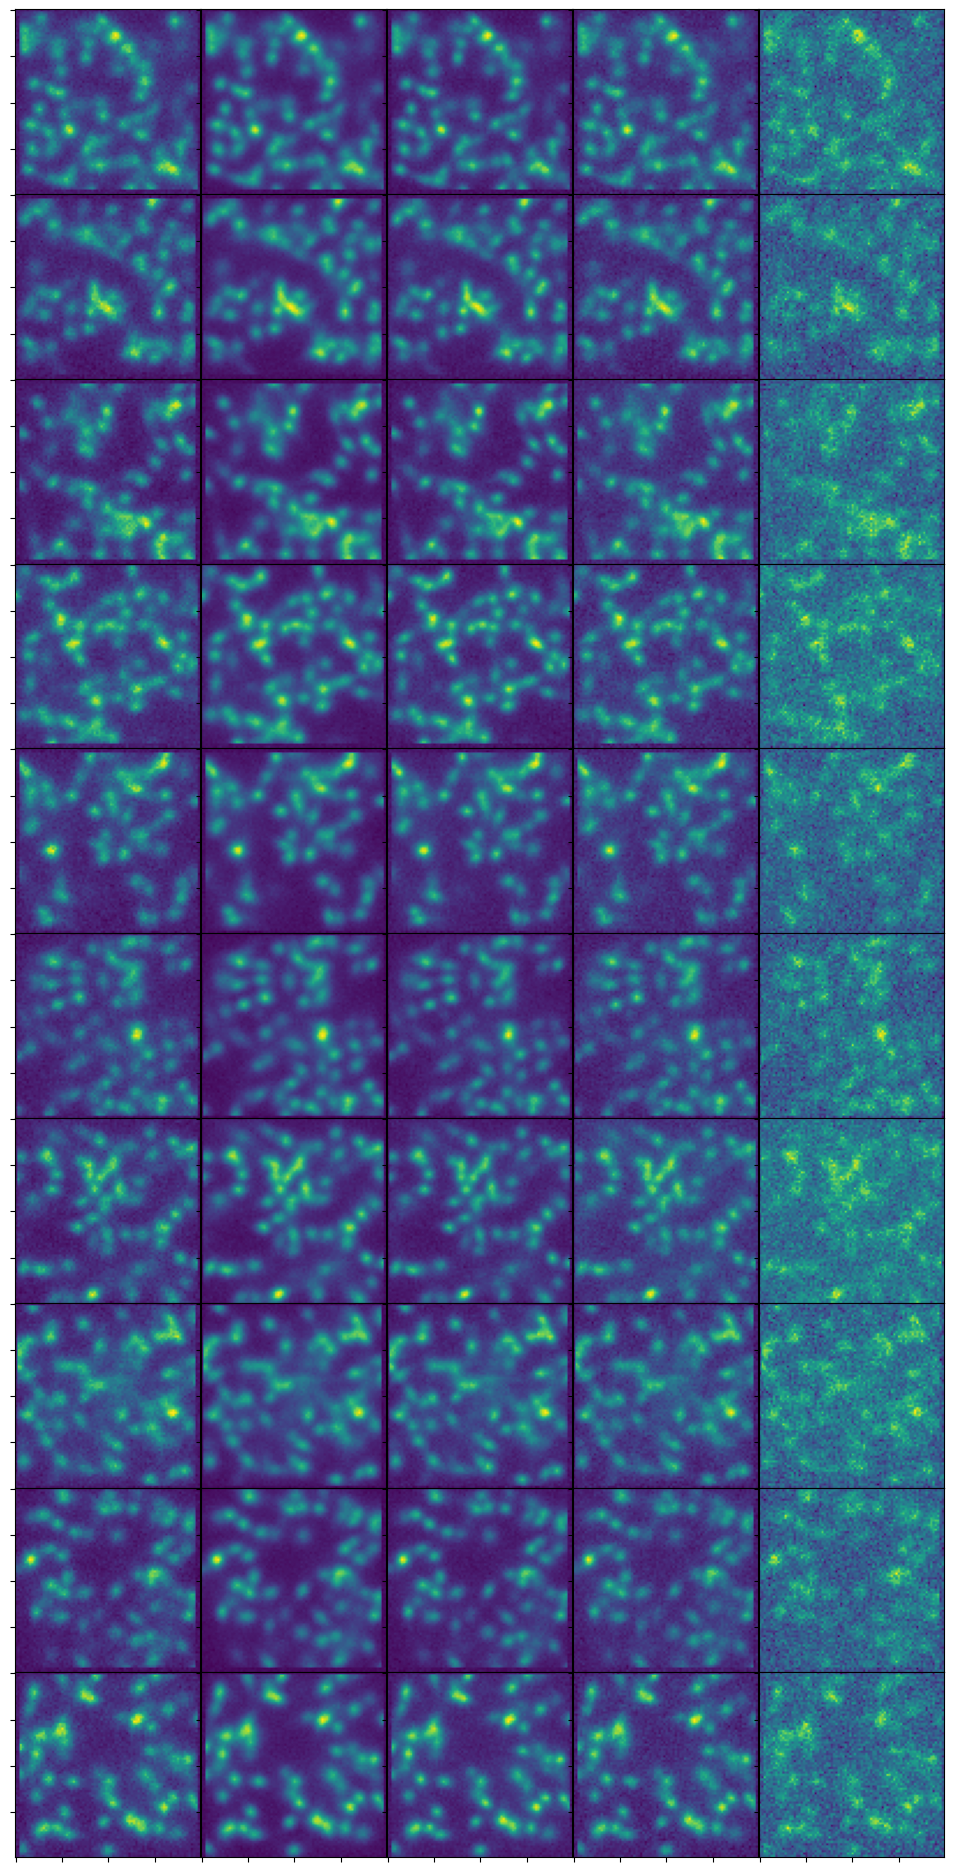

In [19]:
n_to_show = 10
_, axs = plt.subplots(10, 5, figsize=(12,24))
axs = axs.flatten()
imgs = batch['images'][:10].flatten(start_dim=0,end_dim=1)
for img, ax in zip(imgs, axs):
    ax.imshow(img)
    
for a in axs:
    a.set_xticklabels([])
    a.set_yticklabels([])

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### In-Sample Training Results: DC2

We fit the encoder using the BLISS pipeline. Essentially, photo-$z$ estimation is performed via a module in parallel to the existing pipeline: the current pipeline estimates locations, types, and fluxes of each astronomical object. We simply add outputs to the encoder network that are used to parameterize the variational distributions on redshift.

Currently, the variational distributions on redshift are univariate Gaussian; a mixture of Gaussians could be used in the future. As with other quantities, the per-tile NLL contribution for redshift is conditioned on the presence of a true source in that tile, etc. We leave other aspects of BLISS unchanged, so in addition we also estimate the number of sources, the type of each source, the fluxes and galaxy parameters of each source, etc.

Let's load the fitted encoder and check that we are detecting sources properly. We overlay red "x"s on the posterior mode per-tile of the detected source, if a source is detected in that tile. We'll just overlay on top of the r-band image, as we don't have coaddition support for SDSS.

In [20]:
PATH = "/data/scratch/declan/dc2_encoder_ckpt.ckpt"
checkpoint = torch.load(PATH)
encoder.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [21]:
est_cat = encoder.sample(batch, use_mode=True) # I'm using the mode to predict
est_cat = est_cat.to_dict()

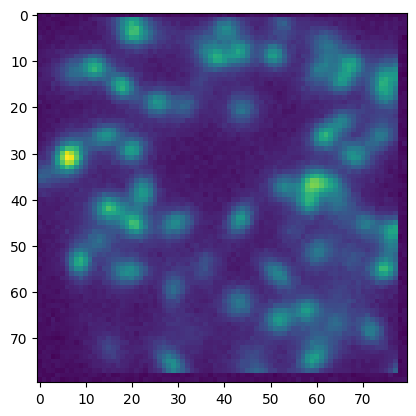

In [22]:
# Plot r_band for a selected image, overlay detected source locations
image_to_show = 8
fig, ax = plt.subplots()
ax.imshow(batch['images'][image_to_show].sum(0)) # Coadd by simple summation

In [23]:
target_cat = RedshiftTileCatalog(encoder.tile_slen, batch["tile_catalog"])
target_cat = target_cat.filter_tile_catalog_by_flux(min_flux=encoder.min_flux_threshold)
target_cat_cropped = target_cat.symmetric_crop(encoder.tiles_to_crop)
est_cat = encoder.sample(batch, use_mode=True)

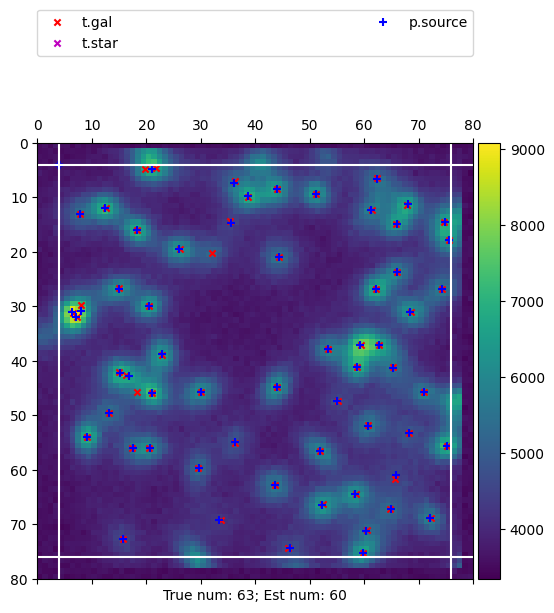

In [24]:
mp = encoder.tiles_to_crop * encoder.tile_slen
fig = my_plot_detections(image_to_show, batch["images"], target_cat_cropped, est_cat, margin_px=mp, figsize=(6,6))

Evidently, we're not doing terribly at predicting sources or their locations; let's assume then that we havne't broken the existing functionality of BLISS. We're interested in the quality of our photometric redshift estimates though. Let's plot these in a scatterplot across the whole training set. This will be quite a dense scatterplot because of the sheer number of images we train on.

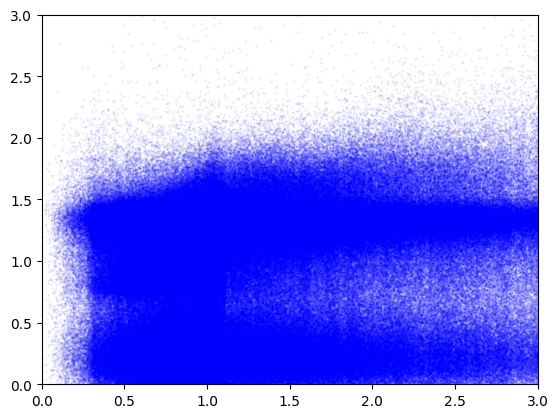

In [26]:
fig, ax = plt.subplots()


for idx, batch in enumerate(train_dataloader):
    est_cat = encoder.sample(batch, use_mode=True)
    pred_redshifts = est_cat.to_dict()['redshifts']
    true_redshifts = batch['tile_catalog']['redshifts']
    
    # Cut out border of true_redshifts
    true_redshifts = true_redshifts[:,1:-1,1:-1]
    true_redshifts = true_redshifts.squeeze(-1)
    
    # Add this batch to scatterplot
    ax.scatter(true_redshifts.detach().numpy(), pred_redshifts.detach().numpy(), c='b', marker='.', s=1, alpha=0.1)
    ax.set_xlim(0,3)
    ax.set_ylim(0,3)
    
    if idx > 100:
        break

In [27]:
training_mean = 0.
for idx, batch in enumerate(train_dataloader):
    true_redshifts = batch['tile_catalog']['redshifts']
    n_batch = 32*18*18
    sum_this_batch = true_redshifts.sum()
    training_mean = (training_mean * (idx * n_batch) + sum_this_batch)/((idx+1)*n_batch)
    
print('Mean of Training Redshifts: {}'.format(training_mean))

Mean of Training Redshifts: 1.644708514213562


### Accessing Standard Deviations to Compute NLL

In [28]:
def marginal_detections(pred_marginal):  # noqa: WPS430
        return pred_marginal.sample(use_mode=False)

pred = encoder.infer(batch, marginal_detections)

In [29]:
pred['marginal'].factors['redshift'].scale

tensor([[[[1.2416],
          [1.2368],
          [0.2971],
          ...,
          [1.2753],
          [1.3068],
          [1.2731]],

         [[0.9672],
          [0.4747],
          [0.6095],
          ...,
          [1.1382],
          [0.6346],
          [1.1634]],

         [[0.5001],
          [0.6022],
          [0.5910],
          ...,
          [0.6557],
          [0.7001],
          [0.6870]],

         ...,

         [[1.0721],
          [0.4331],
          [0.4748],
          ...,
          [1.1664],
          [0.8587],
          [0.6487]],

         [[1.1385],
          [0.2765],
          [0.3842],
          ...,
          [0.6614],
          [0.6392],
          [1.1038]],

         [[1.3146],
          [1.2437],
          [1.0237],
          ...,
          [1.2888],
          [1.1483],
          [1.2638]]],


        [[[1.2008],
          [0.9526],
          [0.6706],
          ...,
          [1.2407],
          [1.0051],
          [0.2253]],

         [[1.2551],
    